# 期现交易

## 摘要



## 理论模型

### 卖出 CTD 基差

卖出 CTD 对应的基差与卖出虚值交割期权相类似. 如果在合约到期之前该国债始终都是 CTD, 那么相应的期权组合到期时仍将是虚值期权, 不存在任何价值. 此时, 基差将逐渐收敛至 0, 而收益取决于当初卖出的基差水平与持有收益之间的差额, 即 BNOC. 


### 卖出非 CTD 的 BNOC

假定收益率不变时, 非 CTD 的 BNOC 随着时间推移并非趋近于 0, 而是趋近于一个正值. 非 CTD 基差的大小更多地取决于它自身的收益率与 CTD 收益率的差额. 卖出非 CTD 基差的动机:
* 通过卖出一揽子可交割债券而非单一的 CTD, 可以有效分散风险, 同时还可以降低头寸关于收益率曲线平坦化或陡峭化的风险敞口
* 卖出非 CTD 而不是 CTD, 还可以获得国债收益率曲线定价偏误带来的收益.


### 买入低价基差

买入基差交易的风险特征类似于期权多头, 损失仅限于 BNOC, 而收益则可能无穷大.

## 实证分析

下面主要以 10 年期国债期货为例进行相关的实证分析.

In [1]:
# coding=utf-8
import time
import sys
import os
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
sys.path.append("C:\\Users\\hushuntai\\svn\\python")

from IPython.display import display
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib.pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
#%matplotlib notebook
import matplotlib.dates as mdate
from tqdm import tqdm_notebook

import QuantStudio.api as QS
WDB = QS.FactorDB.WindDB2();

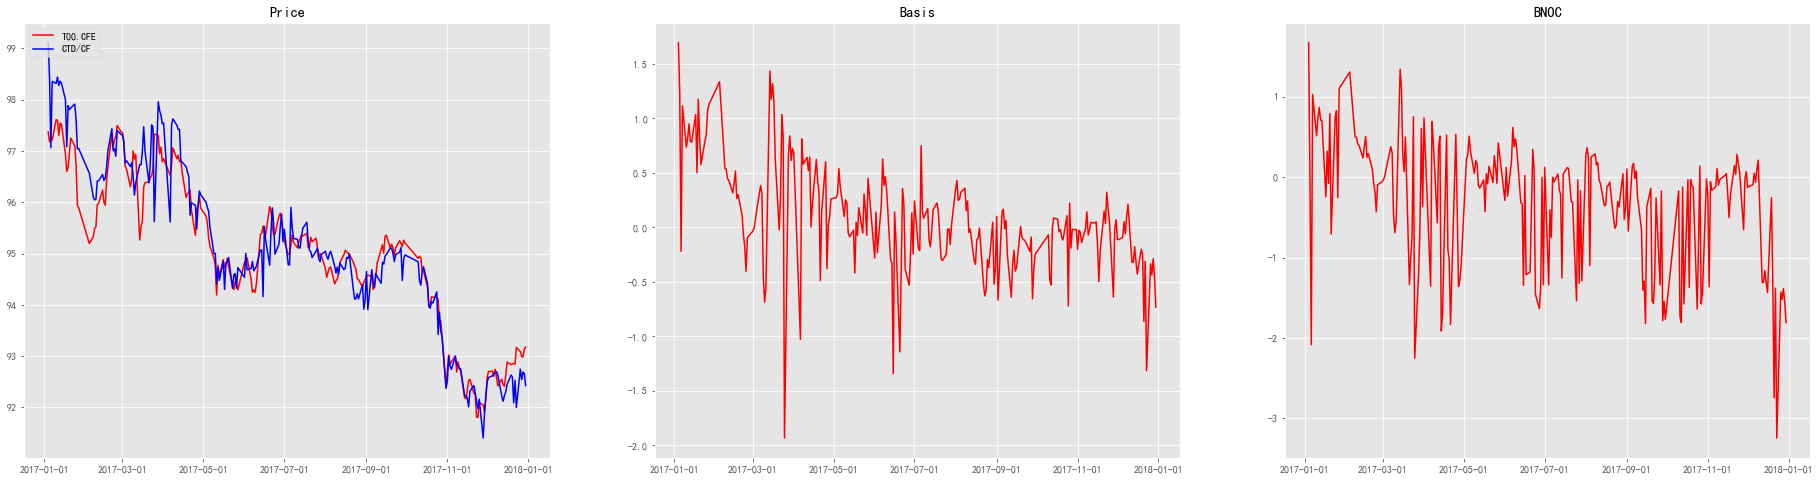

In [15]:
# --------参数设置---------
StartDT = dt.datetime(2017,1,1)
EndDT = dt.datetime(2017,12,31,23,59,59,999999)
FutureID = "T00.CFE"# 主力合约: T.CFE, 当月合约: T00.CFE

# --------准备数据--------
WDB.connect()
FT = WDB.getTable("中国国债期货交易日行情")
DTs = FT.getDateTime(start_dt=StartDT, end_dt=EndDT)
Price = FT.readData(factor_names=["结算价(元)"], ids=[FutureID], dts=DTs).iloc[0]

# 提取CTD券, 转换因子 CF, 计算基差, Carry, BNOC
FutureIDMap = WDB.getTable("中国期货连续(主力)合约和月合约映射表").readData(factor_names=["映射月合约Wind代码"], ids=[FutureID], dts=DTs).iloc[0,:,0]
AllFutureIDs = sorted(FutureIDMap.unique())
LastTradeDay = WDB.getTable("中国期货基本资料").readData(factor_names=["最后交易日期"], ids=AllFutureIDs).iloc[0, 0, :]
FT = WDB.getTable("中国国债期货最便宜可交割券")
CTD, CF, Basis, CarryInterest, SettlementDayNum = pd.Series(index=DTs, dtype="O"), pd.Series(index=DTs), pd.Series(index=DTs), pd.Series(index=DTs), pd.Series(index=DTs)
for i, iID in enumerate(AllFutureIDs):
    iDTs = FutureIDMap[FutureIDMap==iID].index.tolist()
    iCTD = FT.readData(factor_names=["CTD证券Wind代码"], dts=iDTs, ids=[iID]).iloc[0, :, 0]
    CTD.loc[iDTs] = iCTD
    iCTDIDs = iCTD.unique().tolist()
    iCF = WDB.getTable("中国国债期货标的券", args={"缺失填充":True, "缺失填充回溯期数":366, "原始数据回溯天数":366, "月合约Wind代码":iID}).readData(factor_names=["转换因子"], dts=iDTs, ids=iCTDIDs).iloc[0]
    CF.loc[iDTs] = np.diag(iCF.loc[:, iCTD.values].values)
    iAI = WDB.getTable("中国债券应计利息").readData(factor_names=["应计利息"], dts=iDTs, ids=iCTDIDs).iloc[0,:,:]
    iInfo = WDB.getTable("中国国债期货可交割券衍生指标", args={"月合约Wind代码":iID}).readData(factor_names=["区间利息", "交割利息", "基差"], dts=iDTs, ids=iCTDIDs)
    iMask = pd.notnull(iInfo["区间利息"])
    iCarryInterest = pd.DataFrame(np.nan, index=iDTs, columns=iCTDIDs)
    iCarryInterest[iMask] = (iInfo["交割利息"] + iInfo["区间利息"])[iMask]
    iCarryInterest[~iMask] = (iInfo["交割利息"] - iAI)[~iMask]
    Basis.loc[iDTs] = np.diag(iInfo["基差"].loc[:, iCTD.values].values)
    CarryInterest.loc[iDTs] = np.diag(iCarryInterest.loc[:, iCTD.values].values)
    iLastTradeDate = dt.datetime.strptime(LastTradeDay.loc[iID], "%Y%m%d").date()
    SettlementDayNum.loc[iDTs] = [(iLastTradeDate - jDT.date()).days+4 for jDT in iDTs]
CTDIDs = sorted(CTD.unique())
BondCleanPrice = WDB.getTable("中国债券行情-净价").readData(factor_names=["收盘价(元)"], ids=CTDIDs, dts=DTs).iloc[0]
BondDirtyPrice = WDB.getTable("中国债券行情-全价").readData(factor_names=["收盘价(元)"], ids=CTDIDs, dts=DTs).iloc[0]
RP = WDB.getTable("货币市场日行情").readData(factor_names=["加权平均利率"], ids=["DR007.IB"], dts=DTs).iloc[0,:,0]# 资金成本取银行间 7 天质押式回购利率
Price["CTD"], Carry = np.nan, pd.Series(np.nan, index=DTs)
for i, iID in enumerate(BondCleanPrice.columns):
    iMask = (CTD==iID)
    Price["CTD"][iMask] = BondCleanPrice[iID][iMask]
    Carry[iMask] = CarryInterest[iMask] - BondDirtyPrice[iID][iMask]*RP[iMask]/100/365*SettlementDayNum[iMask]
BNOC = Basis - Carry

# 绘制价格图像
Fig, Axes = plt.subplots(1, 3, figsize=(32, 8))
Axes[0].xaxis_date()
Axes[0].xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))
Axes[0].plot(Price.index, Price.values[:, 0], color='r', label=Price.columns[0])
Axes[0].plot(Price.index, Price.values[:, 1]/CF.values, color='b', label=Price.columns[1]+"/CF")
Axes[0].legend(loc='upper left')
Axes[0].set_title("Price")
Axes[1].xaxis_date()
Axes[1].xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))
Axes[1].plot(Basis.index, Basis.values, color='r', label="Basis")
Axes[1].set_title("Basis")
Axes[2].xaxis_date()
Axes[2].xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))
Axes[2].plot(BNOC.index, BNOC.values, color='r', label="BNOC")
Axes[2].set_title("BNOC");

Basis ADF Test Statistic : -9.344746
pvalue : 0.000000
usedlag : 0
Basis Hurst Exponent : 0.012924
BNOC ADF Test Statistic : -3.634577
pvalue : 0.005133
usedlag : 3
BNOC Hurst Exponent : 0.043839


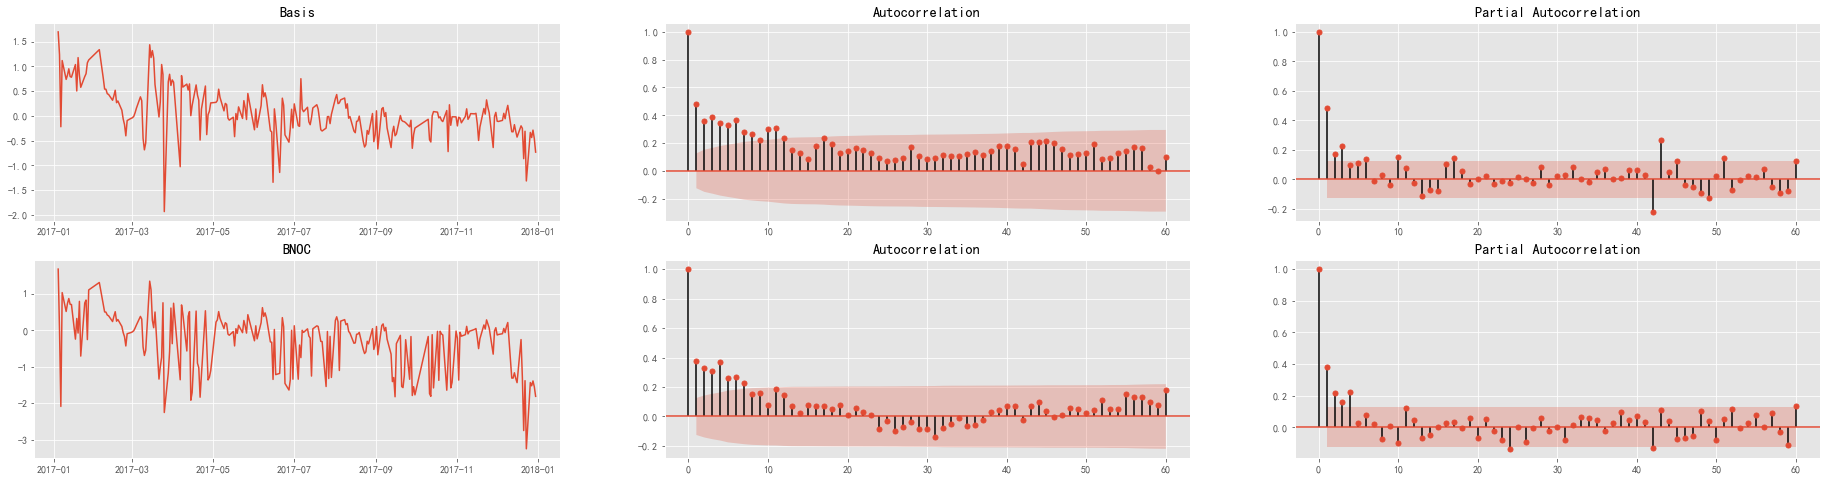

In [16]:
# --------平稳性检验--------
# Basis ADF 检验
BasisADFTest = sm.tsa.stattools.adfuller(Basis.values, regression='c', autolag="BIC")
print(("Basis ADF Test Statistic : %f" % BasisADFTest[0]), 
      ("pvalue : %f" % BasisADFTest[1]), 
      ("usedlag : %d" % BasisADFTest[2]), sep="\n")

# Basis Hurst 指数
BasisHurstExp, _ = QS.Tools.Math.genHurstExp(Basis.values)
print("Basis Hurst Exponent : %f" % BasisHurstExp)

# BNOC ADF 检验
BNOCADFTest = sm.tsa.stattools.adfuller(BNOC.values, regression='c', autolag="BIC")
print(("BNOC ADF Test Statistic : %f" % BNOCADFTest[0]), 
      ("pvalue : %f" % BNOCADFTest[1]), 
      ("usedlag : %d" % BNOCADFTest[2]), sep="\n")

# BNOC Hurst 指数
BNOCHurstExp, _ = QS.Tools.Math.genHurstExp(BNOC.values)
print("BNOC Hurst Exponent : %f" % BNOCHurstExp)

# ACF, PACF
Fig, Axes = plt.subplots(2, 3, figsize=(32, 8))
Axes[0, 0].plot(Basis)
Axes[0, 0].set_title("Basis")
sm.graphics.tsa.plot_acf(Basis, lags=60, ax=Axes[0, 1])
sm.graphics.tsa.plot_pacf(Basis, lags=60, ax=Axes[0, 2]);
Axes[1, 0].plot(BNOC)
Axes[1, 0].set_title("BNOC")
sm.graphics.tsa.plot_acf(BNOC, lags=60, ax=Axes[1, 1])
sm.graphics.tsa.plot_pacf(BNOC, lags=60, ax=Axes[1, 2]);